Task of this file: solve for 1D TV sparse signal.

Formula:

$\min \|D_1x\|_1+\epsilon\|y-Ax\|_2^2,\ \text{st.}\ x\geq 0.$
Here $A=F\Sigma F^H, D_1$ is the circulant different matrix, so $D_1=F\Lambda F^H$.

Iterative algorithms for solving this problem would include a quadratic programming step, for now, I'm only solve for $x^{k+1}$ and force it to be nonnegative (the result is not exactly the same as cvx, but usually close at the best N_recon).

In [ ]:
pip install ipdb

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
import ipdb
import warnings
import time
warnings.filterwarnings("ignore")

The idea for the dominant step:

$(2\epsilon A^TA+\rho I)x=2\epsilon A^Ty+\rho(z-u),\ A^TA=F\Sigma^2F^H$, i.e.,

$F(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon F\Sigma F^Hy+\rho(z-u)$,

$(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon \Sigma F^Hy+\rho F^H(z-u)$,

$x=F(2\epsilon\Sigma^2+\rho I)^{-1}(2\epsilon\Sigma F^Hy+\rho F^H(z-u))$

In [3]:
#ADMM for solving min_x ||D_1x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D TV sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e-1,rho=1):
  #the choice of rho must be careful!
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda = sp.sparse.diags(scipy.fft.fft(a),0)
  x = np.random.randn(N,)
  z = np.random.randn(N,)
  u = np.random.randn(N,)
  F = sp.fft.fft(np.eye(N))/np.sqrt(N)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda.conjugate()@Lambda).diagonal()
  invD = sp.sparse.diags(1/d,0)
  #ipdb.set_trace()
  if constrain == True:
    for i in range(maxit):
      #x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*sp.sparse.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      x = np.maximum(x,0)
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>50 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
      #if np.mod(i,10) == 0:
      #  print(i)
  else: 
    for i in range(maxit):
      #x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>100 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
  return x,err,loss
def l1solv(Fw1,meas,constraint=True,epsilon=1e0):
# Create variable.
   N = len(meas)
   D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
   D1[0,-1] = -1
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D1@x_l1, 1) + epsilon*cp.norm((Fw1@x_l1)-meas, 2)**2)
# Form and solve problem.
   if constraint == False:
    prob = cp.Problem(obj)
   else:
     prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   #plt.plot(x_l1.value,'y')
   #plt.plot(u,'c')
   #plt.plot(meas,'r')
   mx_norm = torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 2))**2*1e-4
   psnr_recon = psnr2(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)

In [4]:
#ADMM with quadratic programming for updating x, but it's still slow 
def myADMM1(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e-1,rho=1):
  #the choice of rho must be careful!
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda = sp.sparse.diags(scipy.fft.fft(a),0)
  x = np.random.randn(N,)
  z = np.random.randn(N,)
  u = np.random.randn(N,)
  F = sp.fft.fft(np.eye(N))/np.sqrt(N)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda.conjugate()@Lambda).diagonal()
  invD = sp.sparse.diags(1/d,0)
  P = np.real(F@(2*epsilon*Sigma**2+rho*Lambda.conjugate()@Lambda)@F.conjugate())
  lb1 = np.zeros((N,))
  print('begin iterations')
  if constrain == True:
    for i in range(maxit):
      #x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*sp.sparse.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      
      #x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      #x = np.maximum(x,0)
      
      q1 = np.real(rho*D1.T@(u-z)-2*epsilon*sp.fft.fft(Sigma@sp.fft.fft(y).conjugate())/N)
      t0 = time.time()
      x = solve_qp(P, q1,lb = lb1)
      t1 = time.time()
      print('time',t1-t0)
      #ipdb.set_trace()
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>50 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
      if np.mod(i,20) == 0:
        print(i)
  else: 
    for i in range(maxit):
      #x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>100 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
  return x,err,loss

In [5]:
#check correctness of the function above, compare with cvx 
def mytest(constraint=False,maxit1=3000,A=[],y=[],epsilon1=1e-1,rho1=1):
  if A == []:
    N = 500
    #A = circulant(np.random.randn(N,1))
    #A = A + A.T
    a = np.zeros(N,)
    a[0],a[1],a[-1] = 0.8,0.1,0.1
    A = circulant(a)
    y = np.random.randn(N,1)
  power = 100
  Sigma1 = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:])),0)
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  x_l1 = cp.Variable(shape=(N,1))
  constraints = [x_l1>=0]
  Ahat = np.linalg.matrix_power(A,power)
  obj = cp.Minimize(cp.norm(D1@x_l1, 1) + epsilon1*cp.norm(y-Ahat@x_l1, 2)**2) 
  if constraint == False:
    prob = cp.Problem(obj)
    x,err = myADMM(Sigma=Sigma1**power,y=y,constrain=False,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  else:
    prob = cp.Problem(obj, constraints)
    x,err,loss = myADMM(Sigma=Sigma1**power,y=y,constrain=True,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  prob.solve()
  x_cvx = x_l1.value
  plt.figure(figsize=(10,5))
  plt.subplot(131),plt.plot(err)
  plt.subplot(132),plt.plot(x,'r'),
  plt.subplot(133),plt.plot(x_cvx,'b')
  psnr_rec = psnr2(x,x_cvx)
  return x,x_cvx,psnr_rec

10.52262565300301


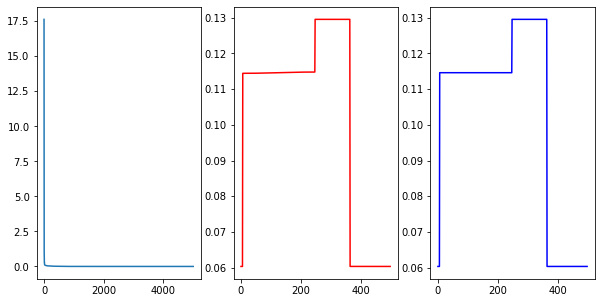

In [8]:
x,x_cvx,psnr_rec=mytest(constraint=True,maxit1=5000,rho1=1)
print(psnr_rec)

In [9]:
#1D sparse signal and its mearsurements
N = 500
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = (1-2*s)*sp.sparse.diags(np.ones((N,)),0) +s*sp.sparse.diags(np.ones((N-1,)),-1)+s*sp.sparse.diags(np.ones((N-1,)),1)
A[0,-1] = s
A[-1,0] = s
D1 = sp.sparse.diags(np.ones((N,)),0)-sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
spikes = 5
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
u = np.cumsum(u)
u = abs(u).reshape(N,1)
k.sort()
u[k[1]+25:k[2]+25] = - u[k[1]+25:k[2]+25]
u[:60] = 0                      
u[-60:] = 0

#Fw = np.linalg.matrix_power(A, Ncount)
#meas = (Fw@u).reshape(N,1)
#noise = 1*np.random.randn(meas.shape[0],1)
#measn = meas + noise  

In [10]:
# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(N-60):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(N-70):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f990a30ce50>,
 [<matplotlib.lines.Line2D at 0x7f990a267ad0>])

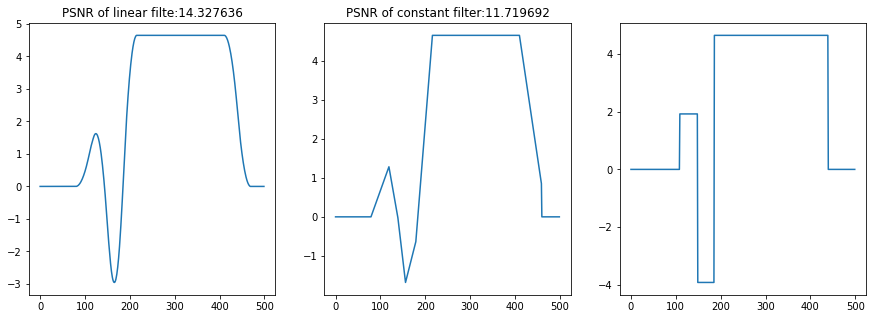

In [11]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [12]:
t = np.linspace(100,2400,20)
a =[]
b =[]
Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:].toarray().reshape(N,))),0)
D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
for ti in range(20):
    u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas1,constrain=False,rho=10,maxit=3000,epsilon=1e-1)
    mix_norm = np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 2.2430388724257786 mixed norm: 25.65937270887998
N: 221.05263157894737 psnr 2.1783172709183067 mixed norm: 21.890684339700506
N: 342.10526315789474 psnr 2.1264251001702257 mixed norm: 21.64986999693661
N: 463.1578947368421 psnr 2.0597214535864414 mixed norm: 20.894805224350772
N: 584.2105263157895 psnr 1.9959262699331721 mixed norm: 18.4285623886203
N: 705.2631578947369 psnr 1.9409670637696939 mixed norm: 18.098179591564815
N: 826.3157894736842 psnr 1.891405086655424 mixed norm: 15.875246536301447
N: 947.3684210526316 psnr 1.8467945358924798 mixed norm: 16.00785112379713
N: 1068.421052631579 psnr 1.8032525144135914 mixed norm: 15.242416008970382
N: 1189.4736842105262 psnr 1.775247698671243 mixed norm: 16.09718254439112
N: 1310.5263157894738 psnr 1.738776073445005 mixed norm: 15.656331205869854
N: 1431.578947368421 psnr 1.7092817266594016 mixed norm: 16.17726024470691
N: 1552.6315789473683 psnr 1.6757703542224107 mixed norm: 16.280573567880886
N: 1673.6842105263158 psnr 1.

In [18]:
meas1.shape

(500, 1)

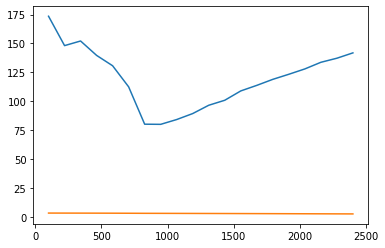

In [ ]:
plt.plot(t,a)
plt.plot(t,b)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f990a0fc390>,
 Text(0.5, 1.0, 'measurement'))

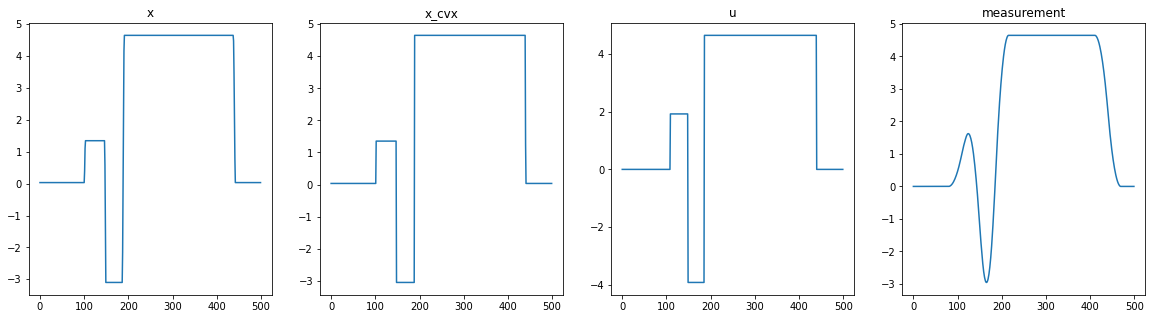

In [13]:
N_recon = np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),meas1,constrain=False,rho=10,maxit=3000,epsilon=1e-1)
x_cvx = l1solv(np.linalg.matrix_power(A.toarray(),int(N_recon)),meas1,constraint=False,epsilon=1e-1)
plt.figure(figsize=(20,5))
plt.subplot(141),plt.plot(x),plt.title('x')
plt.subplot(143),plt.plot(u),plt.title('u')
plt.subplot(142),plt.plot(x_cvx),plt.title('x_cvx')
plt.subplot(144),plt.plot(meas1),plt.title('measurement')

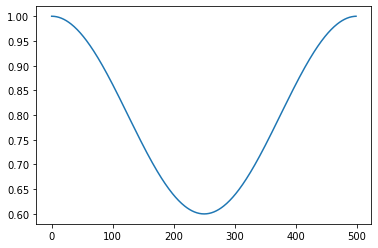

In [21]:
plt.plot(Sigma.toarray().diagonal())

In [ ]:
print('cvx loss',np.linalg.norm(D1@x_cvx, 1)+ np.linalg.norm((np.linalg.matrix_power(A.toarray(),int(N_recon))@x_cvx)-meas1, 2)**2*1e1)
print('ADMM loss',np.linalg.norm(D1@x, 1)+ np.linalg.norm((np.linalg.matrix_power(A.toarray(),int(N_recon))@x)-meas1.reshape(N,), 2)**2*1e1)

cvx loss 149.80788494452267
ADMM loss 149.92991833978326


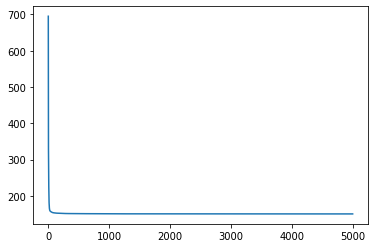

In [ ]:
x,err,loss = myADMM(Sigma**int(N_recon),meas1,constrain=False,rho=10,maxit=5000)
plt.plot(loss)

In [31]:
#1D TV sparse signal and its mearsurements
N = 500
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = (1-2*s)*sp.sparse.diags(np.ones((N,)),0) +s*sp.sparse.diags(np.ones((N-1,)),-1)+s*sp.sparse.diags(np.ones((N-1,)),1)
A[0,-1] = s
A[-1,0] = s
D1 = sp.sparse.diags(np.ones((N,)),0)-sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
spikes = 5
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
u = np.cumsum(u)
u = abs(u).reshape(N,1)
k.sort()
#u[k[1]+25:k[2]+25] = - u[k[1]+25:k[2]+25]
u[:60] = 0                      
u[-60:] = 0

# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(N-60):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(N-70):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)  

(<matplotlib.axes._subplots.AxesSubplot at 0x7f990932af50>,
 [<matplotlib.lines.Line2D at 0x7f9909135110>])

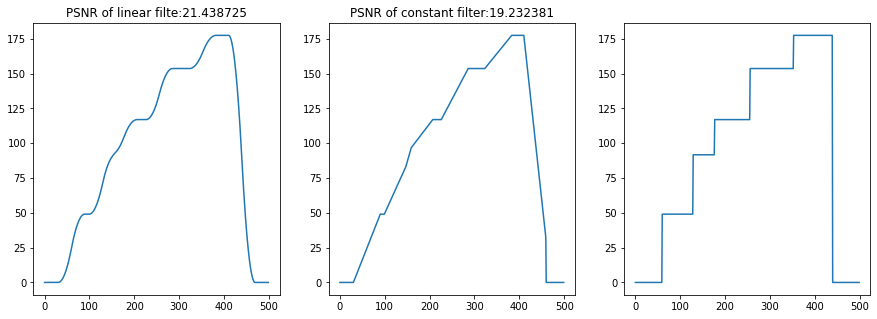

In [32]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [33]:
t = np.linspace(500,1200,20)
a =[]
b =[]
Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:].toarray().reshape(N,))),0)
D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
for ti in range(20):
    u_rec = l1solv(np.linalg.matrix_power(A.toarray(),int(t[ti])),meas1,constraint=False,epsilon=1e-1)
    #u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas1,constrain=False,rho=10,maxit=3000)
    mix_norm = np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 500.0 psnr 20.718119896558285 mixed norm: 82.33859320053448
N: 536.8421052631579 psnr 20.96403885826279 mixed norm: 84.51201503698198
N: 573.6842105263158 psnr 21.122642256773574 mixed norm: 76.0789241736142
N: 610.5263157894738 psnr 21.624761059626863 mixed norm: 83.6762374629624
N: 647.3684210526316 psnr 21.95743282079901 mixed norm: 77.80999023051619
N: 684.2105263157895 psnr 22.685630748231794 mixed norm: 80.11332565150968
N: 721.0526315789474 psnr 23.59174646529869 mixed norm: 79.55071587851862
N: 757.8947368421052 psnr 24.79655182641597 mixed norm: 75.36575308963818
N: 794.7368421052631 psnr 28.947226011689303 mixed norm: 66.98807509620082
N: 831.578947368421 psnr 31.977713831373492 mixed norm: 64.27107321982976
N: 868.421052631579 psnr 31.77630480258194 mixed norm: 65.26723185716541
N: 905.2631578947369 psnr 31.52170947273354 mixed norm: 65.06249051648922
N: 942.1052631578948 psnr 31.08065942111151 mixed norm: 65.92283327636277
N: 978.9473684210527 psnr 30.652146402727098 mix

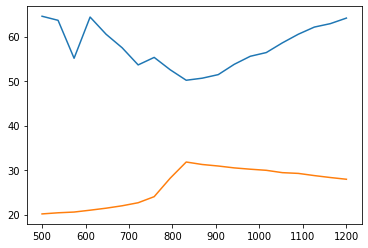

In [ ]:
plt.plot(t,a)
plt.plot(t,b)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9909259dd0>,
 Text(0.5, 1.0, 'measurement'))

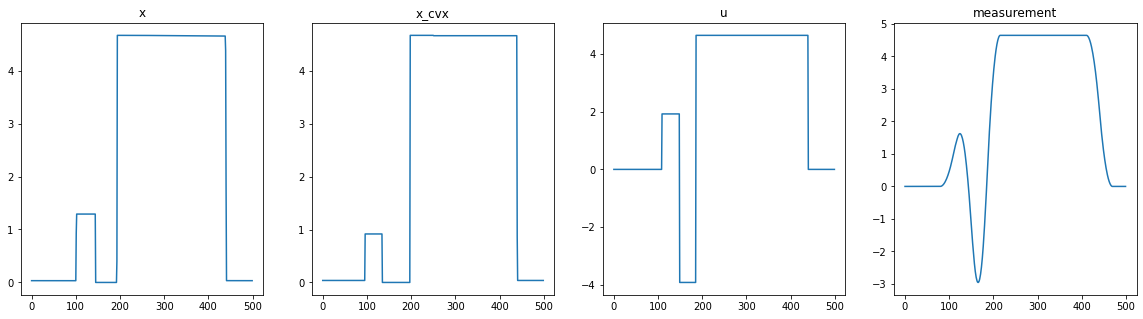

In [29]:
N_recon = np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),meas1,constrain=True,rho=1,maxit=2000,epsilon=1e-1)
x_cvx = l1solv(np.linalg.matrix_power(A.toarray(),int(N_recon)),meas1,constraint=True,epsilon=1e-1)
plt.figure(figsize=(20,5))
plt.subplot(141),plt.plot(x),plt.title('x')
plt.subplot(143),plt.plot(u),plt.title('u')
plt.subplot(142),plt.plot(x_cvx),plt.title('x_cvx')
plt.subplot(144),plt.plot(meas1),plt.title('measurement')

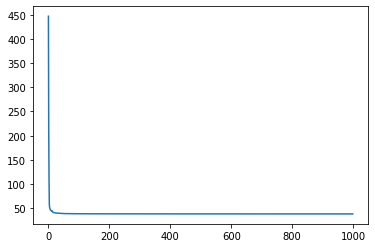

In [25]:
plt.plot(loss)

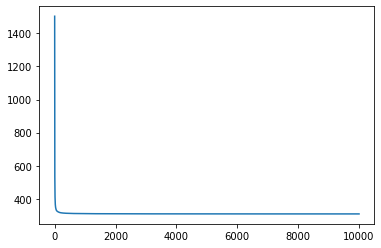

In [ ]:
plt.plot(loss)

In [ ]:
print('cvx loss',np.linalg.norm(D1@x_cvx, 1)+ np.linalg.norm((np.linalg.matrix_power(A.toarray(),int(N_recon))@x_cvx)-meas1, 2)**2*1e-1)
print('ADMM loss',np.linalg.norm(D1@x, 1)+ np.linalg.norm((np.linalg.matrix_power(A.toarray(),int(N_recon))@x)-meas1.reshape(N,), 2)**2*1e-1)

cvx loss 307.9247129723507
ADMM loss 308.3850929879964


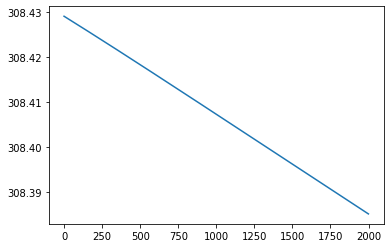

In [ ]:
plt.plot(loss[8000:])